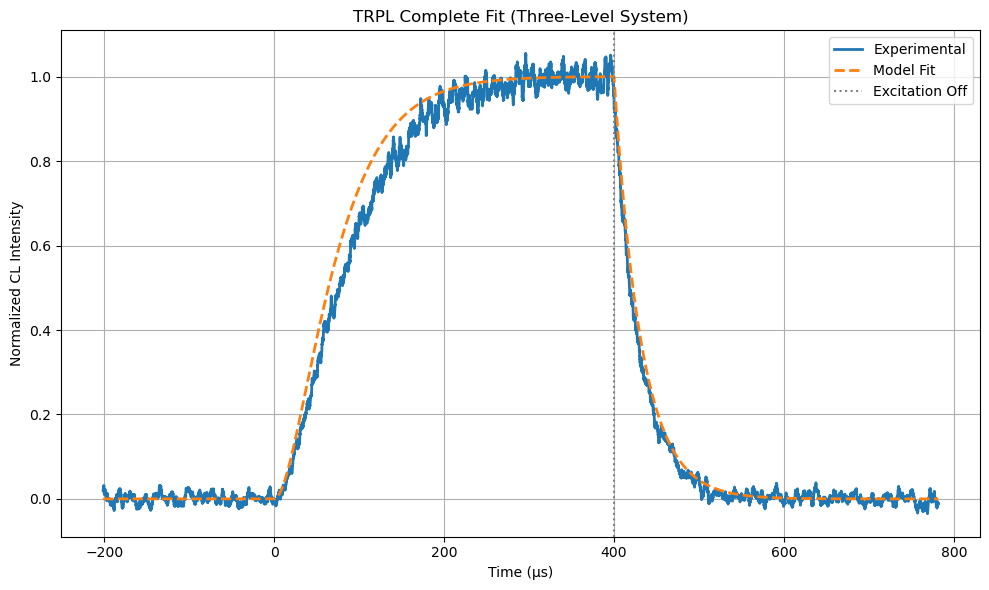

Fit results:
k_exc: 6.7562e-06 µs⁻¹
k_UC: 1.0000e-03 µs⁻¹
k_CL3: 4.7406e-04 µs⁻¹
k_Yb2: 3.0613e-02 µs⁻¹
Output saved to: Z:\Jacob\Material YbEr cluster\06122025 YbYb cluster\fit_output_complete_three.csv


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import os

# === USER INPUTS ===
file_path = r"Z:\Jacob\Material YbEr cluster\06122025 YbYb cluster\TRPL_data.csv"
model_type = "three"  # "three" or "four"
fit_mode = "complete"  # "rise", "decay", or "complete"
tau_Yb = 44.29  # µs

# Parameter bounds
initial_guesses = [0.001, 0.001, 0.001,0.031]  # [k_exc, k_UC, k_CL3, k_Yb2]
lower_bounds = [0.000001, 0.000001, 0.000001,0.03]
upper_bounds = [0.1, 0.1, 0.1,0.1]

# === Load and normalize data ===
df = pd.read_csv(file_path, skiprows=1)
signal = df.iloc[:, 0].to_numpy()
time = df.iloc[:, 1].to_numpy()

baseline = np.mean(signal[(time >= -200) & (time < -100)])
signal -= baseline
signal /= np.mean(signal[(time >= 350) & (time < 400)])

# === Rate Equations ===
def model_rhs(t, y, k_exc, k_UC, k_CL3,k_Yb2):
    k_Yb = 1 / tau_Yb
    excitation_on = 0 <= t <= 400

    if excitation_on:
        if model_type == "three":
            N0, N1, N2 = y
            dN0 = -k_exc * N0 + k_Yb * N1 + k_CL3 * N2
            dN1 = k_exc * N0 - k_exc * N1 + k_Yb2 * N2 - k_Yb * N1
            dN2 = k_exc * N1 - k_Yb2 * N2 - k_CL3 * N2
            return [dN0, dN1, dN2]
        else:
            N0, N1, N2, N3 = y
            dN0 = -k_exc * N0 + k_Yb * N1 + k_CL3 * N3
            dN1 = k_exc * N0 - k_exc * N1 + k_Yb2 * N2 - k_Yb * N1
            dN2 = k_exc * N1 - k_Yb2 * N2 - k_UC * N2
            dN3 = k_UC * N2 - k_CL3 * N3
            return [dN0, dN1, dN2, dN3]
    else:
        if model_type == "three":
            N0, N1, N2 = y
            dN0 = k_Yb * N1 + k_CL3 * N2
            dN1 = k_Yb2 * N2 - k_Yb * N1
            dN2 = -k_Yb2 * N2 - k_CL3 * N2
            return [dN0, dN1, dN2]
        else:
            N0, N1, N2, N3 = y
            dN0 = k_Yb * N1 + k_CL3 * N3
            dN1 = k_Yb2 * N2 - k_Yb * N1
            dN2 = -k_Yb2 * N2 - k_UC * N2
            dN3 = k_UC * N2 - k_CL3 * N3
            return [dN0, dN1, dN2, dN3]

# === Solver and fit wrappers ===
def solve_model(t, k_exc, k_UC, k_CL3,k_Yb2, y0=None):
    if y0 is None:
        y0 = [1.0, 0.0, 0.0, 0.0] if model_type == "four" else [1.0, 0.0, 0.0]
    return solve_ivp(model_rhs, [t[0], t[-1]], y0, t_eval=t, args=(k_exc, k_UC, k_CL3,k_Yb2), rtol=1e-8, atol=1e-10)

def model_wrapper(t, k_exc, k_UC, k_CL3, k_Yb2, y0=None):
    sol = solve_model(t, k_exc, k_UC, k_CL3, k_Yb2, y0)
    yout = sol.y[3 if model_type == "four" else 2] * (k_CL3 if model_type == "three" else k_CL3)
    return yout / np.max(yout)

# === Fit region ===
if fit_mode == "rise":
    mask = (time >= 0) & (time <= 400)
elif fit_mode == "decay":
    mask = (time > 400)
else:
    mask = np.full_like(time, True, dtype=bool)

time_fit = time[mask]
signal_fit = signal[mask]

# === Fit procedure ===
if fit_mode == "rise":
    popt, _ = curve_fit(lambda t, k_exc, k_UC, k_CL3,k_Yb2: model_wrapper(t, k_exc, k_UC, k_CL3,k_Yb2),
                        time_fit, signal_fit, p0=initial_guesses, bounds=(lower_bounds, upper_bounds), maxfev=10000)

elif fit_mode == "decay":
    # Use steady-state from rise to initialize decay
    sol_rise = solve_model(np.linspace(0, 400, 500), *initial_guesses)
    y0_decay = sol_rise.y[:, -1]

    def decay_only_model(t, k_UC, k_CL3,k_Yb2):
        k_exc_fixed = initial_guesses[0]
        return model_wrapper(t, k_exc_fixed, k_UC, k_CL3,k_Yb2, y0=y0_decay)

    popt_partial, _ = curve_fit(decay_only_model, time_fit, signal_fit,
                                p0=initial_guesses[1:], bounds=(lower_bounds[1:], upper_bounds[1:]), maxfev=10000)
    popt = [initial_guesses[0]] + list(popt_partial)

elif fit_mode == "complete":
    popt, _ = curve_fit(lambda t, k_exc, k_UC, k_CL3,k_Yb2: model_wrapper(t, k_exc, k_UC, k_CL3,k_Yb2),
                        time_fit, signal_fit, p0=initial_guesses, bounds=(lower_bounds, upper_bounds), maxfev=10000)

# === Simulate final model fit ===
fit_sim = model_wrapper(time_fit, *popt)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(time_fit, signal_fit, label="Experimental", lw=2)
plt.plot(time_fit, fit_sim, '--', label="Model Fit", lw=2)
plt.axvline(400, color='gray', linestyle=':', label="Excitation Off")
plt.xlabel("Time (µs)")
plt.ylabel("Normalized CL Intensity")
plt.title(f"TRPL {fit_mode.capitalize()} Fit ({model_type.capitalize()}-Level System)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output CSV ===
output_dir = os.path.dirname(file_path)
output_file = os.path.join(output_dir, f"fit_output_{fit_mode}_{model_type}.csv")
header = ", ".join([f"{name}: {val:.4e} µs⁻¹" for name, val in zip(["k_exc", "k_UC", "k_CL3","k_Yb2"], popt)])

fit_df = pd.DataFrame({"Time (µs)": time_fit, "Model Fit": fit_sim})
with open(output_file, "w", encoding="utf-8") as f:
    f.write("# " + header + "\n")
    fit_df.to_csv(f, index=False)

# === Print parameters ===
print("Fit results:")
for name, val in zip(["k_exc", "k_UC", "k_CL3","k_Yb2"], popt):
    print(f"{name}: {val:.4e} µs⁻¹")
print("Output saved to:", output_file)
